In [1]:
import re
import xyzservices.providers as xyz
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import folium
import webbrowser as web
import seaborn as sns
from haversine import haversine, Unit
from folium import plugins
from shapely.geometry import Point

In [2]:
base_date_start = "2022-07-11"
base_date_end = "2022-07-15"

In [3]:
vw_itinerary = pd.read_parquet('itinerary.parquet')

In [4]:
vw_event = pd.read_parquet('events.parquet')
vw_event['hour'] = vw_event["event_timestamp"].dt.hour
vw_event['base_date'] = pd.to_datetime(vw_event["base_date"])
vw_event.query(f"'{base_date_start}' <= base_date <= '{base_date_end}'", inplace = True)
vw_event.query("6 <= hour <= 19", inplace = True)

In [5]:
def extract_terminal_name(x):
    if isinstance(x, str):
        pattern = r'Terminal (Capão da Imbuia|Pinheirinho|Portão|Bairro Alto|Barreirinha|Boa Vista|Boqueirão|Cabral|Cachoeira|Caiuá|Campina do Siqueira|Campo Comprido|Capão Raso|Carmo|Centenário|CIC|Fazendinha|Hauer|Maracanã|Oficinas|Pinhais|Santa Cândida|Santa Felicidade|Sítio Cercado|Tatuquara)'

        match = re.search(pattern, x)
        if match:
            return match.group()
    return x

In [6]:
dim_bus_stop = pd.read_parquet('dim_bus_stop.parquet').drop(columns=['last_update'])
dim_bus_stop['name_normalized'] = np.where( (dim_bus_stop.type_norm == 'Bus terminal'),  dim_bus_stop.name , '')
dim_bus_stop['name_normalized'] = dim_bus_stop['name_normalized'].apply(extract_terminal_name)
terminais_dummy_ids = dim_bus_stop.query("~name_normalized.isna() and name_normalized != ''").groupby(['name_normalized']).agg(dummy_legacy_id = ('legacy_id', 'sum')).reset_index()
dim_bus_stop = dim_bus_stop.merge(terminais_dummy_ids, on=['name_normalized'], how='left')
dim_bus_stop['dummy_legacy_id'] = np.where( (dim_bus_stop.name_normalized == '') , dim_bus_stop.legacy_id, dim_bus_stop.dummy_legacy_id)
dim_bus_stop['dummy_legacy_id'] = dim_bus_stop.dummy_legacy_id.astype(int)

In [7]:
a = vw_itinerary.copy()
a = pd.merge(a, vw_event.filter(['line_code', 'itinerary_id']).drop_duplicates(), on = ['line_code', 'itinerary_id'], how = 'inner')

In [8]:
a = pd.merge(a, dim_bus_stop.filter(['legacy_id', 'dummy_legacy_id']), left_on = 'legacy_id', right_on = 'legacy_id', how = 'left').drop(columns = ['legacy_id'])

In [9]:
bs = dim_bus_stop.copy()
bs['name_normalized'] = np.where( (bs.name_normalized == ''), bs.name, bs.name_normalized)
bs = bs.filter(['dummy_legacy_id', 'name_normalized', 'type_norm', 'latitude', 'longitude']).groupby(by = ['dummy_legacy_id', 'name_normalized', 'type_norm']).agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()
a = pd.merge(a, bs)

In [14]:
# Flag para usar o cluster
use_clusters = False

# Detecta os hubs que não são terminais
hub = a.groupby(by = ['dummy_legacy_id', 'type_norm']).agg({'line_code': 'nunique'}).reset_index()
hid = list(hub.query("line_code > 1 and type_norm != 'Bus terminal'").dummy_legacy_id.drop_duplicates())

if use_clusters:
    # Pontos de ônibus clusterizados
    bus_stop_clustered = pd.read_csv("bus_stop_clustered.csv")
    bus_stop_clustered = pd.merge(bus_stop_clustered, dim_bus_stop.filter(['legacy_id', 'dummy_legacy_id'])).filter(['cluster', 'dummy_legacy_id'])

    hid = list(set(hid) - set(list(bus_stop_clustered.dummy_legacy_id)))

In [15]:
a['id'] = a.dummy_legacy_id.apply(str)
for idx, row in a.query("dummy_legacy_id in @hid").iterrows():
    a.at[idx, 'id'] = str(row['dummy_legacy_id']) + '-' + row['line_code']

In [16]:
g = nx.DiGraph()

nodes = []
for id in a.id.unique():
    dummy_legacy_id = int(id.split('-')[0])
    attr = a.query(f"dummy_legacy_id == {dummy_legacy_id}").filter(['dummy_legacy_id', 'type_norm', 'name', 'latitude', 'longitude', 'line_code']).to_dict('records')
    node = (id, attr[0])
    nodes.append(node)
    
g.add_nodes_from(nodes)    

In [17]:
# Arestas da rede estática
edges = []
dist = pd.read_csv("dist_google.csv")
for line_code in a.line_code.unique():
    itineraries = len(a.query(f"line_code == '{line_code}'").itinerary_id.unique())
    for itinerary_id in a.query(f"line_code == '{line_code}'").itinerary_id.unique():
        points = list(a.query(f"line_code == '{line_code}' and itinerary_id == {itinerary_id}").sort_values(by = 'seq').id.to_numpy())
        if itineraries == 1:
            points.append(points[0])        
        for i in range(0, len(points) - 1):
            u = g.nodes[points[i]]['dummy_legacy_id']
            v = g.nodes[points[i + 1]]['dummy_legacy_id']
            try:
                attr = {'weight': dist.query("id0 == @u and id1 == @v").dist.values[0],
                       'line_code': line_code, 'itinerary_id': itinerary_id}
            except:
                attr = {'weight': haversine((g.nodes[points[i]]['latitude'], g.nodes[points[i]]['longitude']), (g.nodes[points[i + 1]]['latitude'], g.nodes[points[i + 1]]['longitude']), unit = Unit.METERS),
                       'line_code': line_code, 'itinerary_id': itinerary_id}
                print((u, v))
            edges.append((points[i], points[i + 1], attr))                        
g.add_edges_from(edges)            

if use_clusters:
    # Arestas de integração temporal
    edges = []
    for cluster in bus_stop_clustered.cluster.drop_duplicates():
        ids = list(bus_stop_clustered.query(f"cluster == {cluster}").dummy_legacy_id)
        try:
            for u in list(a.query("dummy_legacy_id in @ids").id):
                for v in list(a.query("dummy_legacy_id in @ids").id):
                    if u.split('-')[0] != v.split('-')[0]:
                        attr = {'weight': haversine((g.nodes[u]['latitude'], g.nodes[u]['longitude']), (g.nodes[v]['latitude'], g.nodes[v]['longitude']), unit = Unit.METERS),
                               'line_code': f"cluster-{cluster}", 'itinerary_id': f"cluster-{cluster}"}
                        edges.append((u, v, attr))  
        except Exception as ex:
            print(ex)
    g.add_edges_from(edges)

(1162356, 150783)
(150783, 150784)
(150784, 150785)
(150785, 150884)
(150884, 150749)
(150749, 150760)
(150760, 150786)
(150786, 150761)
(150761, 150895)
(150895, 150421)
(150421, 150787)
(150787, 150788)
(150788, 150339)
(150339, 150340)
(150340, 150897)
(150897, 150341)
(150341, 150342)


In [18]:
nx.write_gexf(g, "curitiba.gexf")

In [19]:
m = []
for edge in g.edges(data = False):
    u = g.nodes[edge[0]]
    v = g.nodes[edge[1]]
    r = (edge[0], u['latitude'], u['longitude'], edge[1], v['latitude'], v['longitude'], -1)
    m.append(r)
dist = pd.DataFrame(m, columns = ['id0', 'lat0', 'long0', 'id1', 'lat1', 'long1', 'dist'])    

In [10]:
od = pd.read_csv("od.csv")

In [11]:
viagens = od.query("MUNICIPIO_ == 'CURITIBA' and MEIO == 'înibus município de Curitiba'").filter(['VIAGEM', 'LAT_ORIGEM', 'LONG_ORIGEM', 'LAT_DESTINO', 'LONG_DESTINO']).copy()
viagens['dist'] = viagens.apply(lambda row: haversine((row['LAT_ORIGEM'], row['LONG_ORIGEM']), (row['LAT_DESTINO'], row['LONG_DESTINO']), unit = Unit.METERS), axis = 1)

In [12]:
def procurar_bus_stops(bus_stops, point, radius, limit_size):
    dummy_legacy_ids = []
    for idx, bus_stop in bus_stops.iterrows():
        d = haversine((bus_stop['latitude'], bus_stop['longitude']), point, unit = Unit.METERS)
        if d <= radius:            
            dummy_legacy_ids.append((bus_stops.loc[idx]['dummy_legacy_id'], d))  
    dummy_legacy_ids = list(pd.DataFrame(dummy_legacy_ids, columns = ['dummy_legacy_id', 'd']).sort_values(by = 'd', ascending = True).dummy_legacy_id.head(limit_size))
    return list(bus_stops.query("dummy_legacy_id in @dummy_legacy_ids")['id'].drop_duplicates())

In [13]:
MIN_DIST = 5000

if use_clusters:
    viagensid = list(pd.read_csv('paths_sem_clusters.csv').viagem.drop_duplicates())
    samples = viagens.query("VIAGEM in @viagensid").filter(['VIAGEM', 'LAT_ORIGEM', 'LONG_ORIGEM', 'LAT_DESTINO', 'LONG_DESTINO']).copy()
else:
    samples = viagens.query(f"dist >= {MIN_DIST}").sample(n = 500, replace = False).filter(['VIAGEM', 'LAT_ORIGEM', 'LONG_ORIGEM', 'LAT_DESTINO', 'LONG_DESTINO']).copy()

NameError: name 'use_clusters' is not defined

In [24]:
a.head()

,line_code,itinerary_id,seq,dummy_legacy_id,name_normalized,type_norm,latitude,longitude,id
0,010,2701,0,140187,"Rua Iapó, 842 - Prado Velho",Street bus stop,-25.449416,-49.254228,140187-010
1,472,706,10,140187,"Rua Iapó, 842 - Prado Velho",Street bus stop,-25.449416,-49.254228,140187-472
2,010,2701,1,140269,"Rua Comendador Roseira, 416 - Prado Velho",Street bus stop,-25.450189,-49.255166,140269-010
3,050,493,22,140269,"Rua Comendador Roseira, 416 - Prado Velho",Street bus stop,-25.450189,-49.255166,140269-050
4,175,8657,1,140269,"Rua Comendador Roseira, 416 - Prado Velho",Street bus stop,-25.450189,-49.255166,140269-175


In [ ]:
K = 30
D = 600
L = 3
paths = []
b = a.filter(['id', 'dummy_legacy_id', 'latitude', 'longitude', 'name_normalized']).drop_duplicates()
count = 1
for index, viagem in samples.iterrows():
    
    print("Viagem {0} de {1} ({2:.2f}%)".format(count, len(samples), 100 * count / len(samples)))
    
    p0 = (viagem['LAT_ORIGEM'], viagem['LONG_ORIGEM'])
    p1 = (viagem['LAT_DESTINO'], viagem['LONG_DESTINO'])
    
    # procura os bus stops de origem dentro do raio D
    origem = procurar_bus_stops(b, p0, D, L)
    
    # procura os bus stops de destino dentro do radio D
    destino = procurar_bus_stops(b, p1, D, L)
        
    combinacoes = []
    for o in origem:
        for d in destino:
            combinacoes.append((o, d))

    for comb in combinacoes:
        try:
            idx = 0
            for p in nx.shortest_simple_paths(g, source = comb[0], target = comb[1], weight = 'weight'):                
                aux = []
                for i in range(0, len(p) - 1):
                    d = g.get_edge_data(p[i], p[i + 1]).copy()
                    d.update({'id': p[i + 1]})
                    aux.append(d)
                path = pd.merge(b.query("id in @p"), pd.DataFrame(aux), how = 'left')
                path['order'] = path['id'].apply(lambda x: p.index(x))
                path.sort_values(by = 'order', inplace = True)
                path['idx'] = idx
                path['viagem'] = int(viagem['VIAGEM'])
                path['p0_lat'] = p0[0]
                path['p0_long'] = p0[1]
                path['p1_lat'] = p1[0]
                path['p1_long'] = p1[1]
                path['comb0'] = comb[0]
                path['comb1'] = comb[1]
                paths.append(path)                
                idx = idx + 1
                if idx > K:
                    break                
        except Exception as e:
            continue
    count = count + 1
paths = pd.concat(paths)
if use_clusters:
    paths.to_parquet('paths_com_clusters.parquet', index = False)
else:
    paths.to_parquet('paths_sem_clusters.parquet', index = False)

In [47]:
paths_sem_clusters = pd.read_parquet('paths_sem_clusters.parquet')
paths_sem_clusters['topologia'] = 'Sem clusters'
paths_com_clusters = pd.read_parquet('paths_com_clusters.parquet')
paths_com_clusters['topologia'] = 'Com clusters'
paths = pd.concat([paths_sem_clusters, paths_com_clusters])
paths['cluster'] = np.where(paths['line_code'].str.contains('cluster'), paths['line_code'], np.NaN)
paths['line_code'] = np.where(paths['line_code'] == 'nan', np.NaN, paths['line_code'])
paths['comb0'] = paths['comb0'].astype(str)
paths['comb1'] = paths['comb1'].astype(str)
melhores = []
for viagem in list(paths.viagem.drop_duplicates()):
    melhores.append(paths.query(f"viagem == {viagem} and topologia == 'Sem clusters'").groupby(['viagem', 'p0_lat', 'p0_long', 'p1_lat', 'p1_long', 'comb0', 'comb1', 'idx', 'topologia']).agg({'weight': 'sum', 'line_code': 'nunique', 'cluster': 'nunique'}).reset_index().sort_values(by = ['line_code', 'weight'], ascending = True).head(1))
    melhores.append(paths.query(f"viagem == {viagem} and topologia == 'Com clusters'").groupby(['viagem', 'p0_lat', 'p0_long', 'p1_lat', 'p1_long', 'comb0', 'comb1', 'idx', 'topologia']).agg({'weight': 'sum', 'line_code': 'nunique', 'cluster': 'nunique'}).reset_index().sort_values(by = ['line_code', 'weight'], ascending = True).head(1))
melhores = pd.concat(melhores)
melhores['baldeacoes'] = melhores['line_code'] - melhores['cluster'] - 1

In [48]:
D = 600
viagens_invalidas = []
b = a.filter(['id', 'name_normalized','latitude', 'longitude']).drop_duplicates()
for idx_viagem, viagem in melhores.query("topologia == 'Com clusters'").iterrows():
    try:
        comb0 = list(b.query(f"id == '{viagem['comb0']}'").filter(['latitude', 'longitude']).to_records(index = False))[0]
        p0 = (viagem['p0_lat'], viagem["p0_long"])
        comb1 = list(b.query(f"id == '{viagem['comb1']}'").filter(['latitude', 'longitude']).to_records(index = False))[0]
        p1 = (viagem['p1_lat'], viagem["p1_long"])
        d0 = haversine(p0, comb0, unit = Unit.METERS)
        d1 = haversine(p1, comb1, unit = Unit.METERS)
        melhores.at[idx_viagem, 'd0'] = d0
        melhores.at[idx_viagem, 'd1'] = d1
        if d0 > D or d1 > D:
            viagens_invalidas.append(viagem['viagem'])
    except:
        continue

In [49]:
df = melhores.query("viagem not in @viagens_invalidas").copy()
viagemsampled = list(df.query("topologia == 'Sem clusters'").sample(n = 200, replace = False).viagem)
df.query("viagem in @viagemsampled", inplace = True)
len(df)

400

In [50]:
df['topologia'] = df['topologia'].str.replace(' ', '\n')
df['weight'] = df['weight'] / 1000

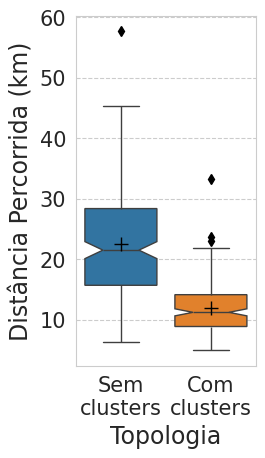

In [51]:
fig, axes = plt.subplots(figsize = (3, 5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker='d', markerfacecolor='black', markersize=5,  markeredgecolor='black')
meanprops = dict(marker='+', markerfacecolor='black', markersize=10,  markeredgecolor='black')
g = sns.boxplot(x = df.topologia, hue = df.topologia, y = df.weight, linewidth = 1.0, notch = True, showfliers = True, showmeans = True, order = ["Sem\nclusters", "Com\nclusters"], palette = sns.color_palette("tab10", 2), ax = axes, flierprops = flierprops, meanprops = meanprops)
g.tick_params(labelsize = 15)
g.set_xlabel("Topologia", fontsize = 17)
g.set_ylabel("Distância Percorrida (km)", fontsize = 17)
plt.subplots_adjust(left=0.3, right=0.9, bottom=0.2, top=0.9)
fig.savefig('comparativo_custo.png', format='png', dpi=300)

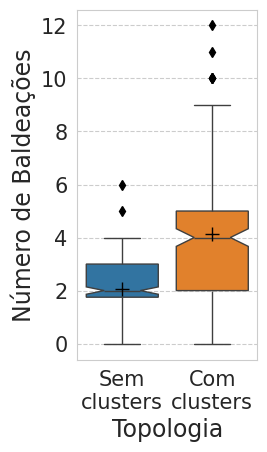

In [52]:
fig, axes = plt.subplots(figsize = (3, 5))
sns.set_style("whitegrid", {'grid.linestyle': '--'})
flierprops = dict(marker = 'd', markerfacecolor = 'black', markersize = 5,  markeredgecolor = 'black')
meanprops = dict(marker = '+', markerfacecolor = 'black', markersize = 10,  markeredgecolor = 'black')
g = sns.boxplot(x = df.topologia, hue = df.topologia, y = df.baldeacoes, linewidth = 1.0, notch = True, showfliers = True, showmeans = True, order = ["Sem\nclusters", "Com\nclusters"], palette = sns.color_palette("tab10", 2), ax = axes, flierprops = flierprops, meanprops = meanprops)
g.tick_params(labelsize = 15)
g.set_xlabel("Topologia", fontsize = 17)
g.set_ylabel("Número de Baldeações", fontsize = 17)
plt.subplots_adjust(left=0.3, right=0.9, bottom=0.2, top=0.9)
fig.savefig('comparativo_custo_baldeacao.png', format='png', dpi=300)

In [60]:
df.groupby('topologia').agg({'weight': 'mean', 'baldeacoes': 'mean'}).reset_index()

,topologia,weight,baldeacoes
0,Com\nclusters,12.037218,4.125
1,Sem\nclusters,22.516135,2.075


In [61]:
viagem = 1513332

mapa = folium.Map(
    location = [-25.4284, -49.2733],
    tiles = "OpenStreetMap",
    zoom_start = 12
)

attr = {'fill': 'black', 'font-weight': 'bold', 'font-size': '12'}
colors = [    
    'blue',
    'gray',
    'darkred',
    'orange',
    'green',
    'darkblue',
    'lightblue',
    'purple',
    'pink',
    'cadetblue',
    'lightgray',
    'blue',
    'gray',
    'darkred',
    'orange',
    'green',
    'darkblue',
    'lightblue',
    'purple',
    'pink',
    'cadetblue',
    'lightgray'    
]

b = a.filter(['id', 'name_normalized','latitude', 'longitude']).drop_duplicates()

for topologia in list(paths.topologia.drop_duplicates()):

    for index_comb, comb in paths.query(f"viagem == {viagem} and topologia == '{topologia}'").groupby(['p0_lat', 'p0_long', 'p1_lat', 'p1_long', 'comb0', 'comb1', 'idx']).agg({'weight': 'sum', 'line_code': 'nunique'}).reset_index().sort_values(by = ['line_code', 'weight'], ascending = True).head(1).iterrows():

        i = 0
        c = 0
        pontos = []
        p0 = None
        lc = None

        path = paths.query(f"comb0 == '{comb['comb0']}' and comb1 == '{comb['comb1']}' and idx == {comb['idx']} and topologia == '{topologia}'").copy()

        lines = path.line_code.nunique()
        clusters = path.cluster.nunique()
        length = path.weight.sum()

        feature_group = folium.FeatureGroup(name = f"topologia: {topologia} baldeacoes: {lines - clusters - 1} length: {length}")

        p0 = (comb['p0_lat'], comb['p0_long']) 

        folium.Marker(p0, popup = "Origem", 
                icon = folium.Icon(
                color = "red",
                prefix = "fa",
                icon = "house"
            )).add_to(feature_group)    

        for index, bus_stop in path.iterrows():

            p = [bus_stop["latitude"], bus_stop["longitude"]]       
            if lc is not None:
                if lc != bus_stop['line_code']:
                    if i > 1:
                        c = c + 1

            vcolor = colors[c]        
            if i > 0:
                lcolor = colors[c]
            else:
                lcolor = "red"        
            folium.Marker(p, popup = bus_stop["name_normalized"], 
                    icon = folium.Icon(
                    color = vcolor,
                    prefix = "fa",
                    icon = "bus"
                )).add_to(feature_group)        
            line = folium.PolyLine([p, p0], color = lcolor).add_to(feature_group)
            plugins.PolyLineTextPath(
                line,
                bus_stop['line_code'],
                center = True,
                offset = 12,
                attributes = attr).add_to(feature_group)
            p0 = p
            lc = bus_stop['line_code']
            i = i + 1

        p = (comb['p1_lat'], comb['p1_long'])
        folium.Marker(p, popup = "Destino", 
                icon = folium.Icon(
                color = "black",
                prefix = "fa",
                icon = "flag-checkered"
            )).add_to(feature_group)      
        line = folium.PolyLine([p, p0], color = "black").add_to(feature_group)

        mapa.add_child(feature_group)
    
mapa.add_child(folium.LayerControl()) 
    
plugins.Fullscreen(                                                         
        position                = "topright",                                   
        title                   = "Open full-screen map",                       
        title_cancel            = "Close full-screen map",                      
        force_separate_button   = True,                                         
    ).add_to(mapa) 

mapa.save(outfile = "map.html")
web.open_new_tab("map.html")

False

In [35]:
melhores.query("topologia == 'Com clusters'").sort_values('line_code').head(30)

,viagem,p0_lat,p0_long,p1_lat,p1_long,comb0,comb1,idx,topologia,weight,line_code,cluster,baldeacoes
0,2163936,-25.460698,-49.209698,-25.428520,-49.262815,108145-302,109036,0,Com clusters,9734.000000,3,0,1
186,1137632,-25.430218,-49.266688,-25.444620,-49.219362,110003,108151-302,0,Com clusters,7774.787893,4,1,1
93,1922995,-25.376871,-49.323518,-25.425391,-49.320560,190454,190949,0,Com clusters,7219.499450,4,1,1
93,1049304,-25.426974,-49.261087,-25.475594,-49.200109,110072,140098-331,0,Com clusters,13472.678445,4,1,1
62,1513332,-25.493038,-49.293987,-25.529766,-49.336522,170170,171007,0,Com clusters,11373.879540,4,2,0
33,547282,-25.432517,-49.275583,-25.428960,-49.329488,103303,190003-870,2,Com clusters,6196.194889,4,2,0
155,1806762,-25.369660,-49.213188,-25.414221,-49.236389,120467,130276,0,Com clusters,14839.000000,4,0,2
31,540322,-25.427016,-49.350035,-25.427262,-49.287110,190073-040,190824,0,Com clusters,9935.194011,5,2,1
124,1012002,-25.563528,-49.341859,-25.499335,-49.328058,170649-773,180084-040,0,Com clusters,8372.428353,5,2,1
31,2236346,-25.422733,-49.262063,-25.482118,-49.203523,110041,140090,0,Com clusters,13161.527996,5,2,1


In [37]:
melhores.query(f"viagem == {viagem}")

,viagem,p0_lat,p0_long,p1_lat,p1_long,comb0,comb1,idx,topologia,weight,line_code,cluster,baldeacoes
63,1137632,-25.430218,-49.266688,-25.44462,-49.219362,110003-373,108151-302,1,Sem clusters,21600.000000,4,0,2
186,1137632,-25.430218,-49.266688,-25.44462,-49.219362,110003,108151-302,0,Com clusters,7774.787893,4,1,1
